In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem
from group_selfies import (
    fragment_mols, 
    Group, 
    MolecularGraph, 
    GroupGrammar, 
    group_encoder
)

from rdkit.Chem.Draw import IPythonConsole

from IPython.display import display
from test_utils import *
from rdkit import RDLogger

RDLogger.DisableLog('rdApp.*') 



### Introduction to Group-SELFIES
Group-SELFIES extends SELFIES with tokens that can specify substructures ("groups"), making the representation more efficient and facilitating more complex manipulations (e.g. functional group replacement, scaffold hopping, etc.)

You can define the set of groups you want to use in your representation using a "grammar".

The encoding/decoding process is similar to SELFIES, except for the inclusion of an additional step in the encoding process to extract the occurence of groups in the molecule to be encoded.

### Defining groups
Group SELFIES defines groups as regular molecules with certain places where branches can be made, which are known as attachment points. 

To represent attachment points, we use "`*`" followed by a number (e.g. `*1`). This number represents the valency of the attachment point (i.e. the maximum bond order of the branch that can come off it). 

For instance:

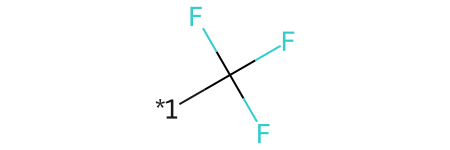

In [3]:
g = Group('trifluoromethane', '*1C(F)(F)F') #creating a group
display(g.mol)

This example group has an attachment point coming off of the carbon atom with a valency of 1. This means that only single bond branches are valid here. 

In some cases, it is useful to have attachment points coming off of all valid atoms in a molecule. To make this process less tedious, an option has been included to add all valid attachment points.  

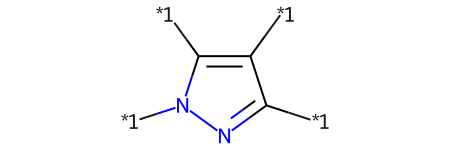

In [4]:
g2 = Group('pyrazole', 'N1C=CC=N1', all_attachment=True) #creating a group where all atoms have attachment points
display(g2.mol)

Note that this feature only adds ONE attachment point per atom; due to the way Group SELFIES works, this prevents multiple branches from coming off of one atom. If that is desired, you must manually specify your group.

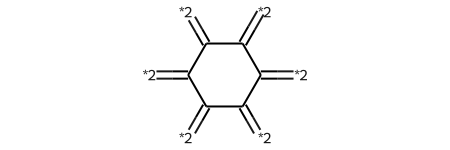

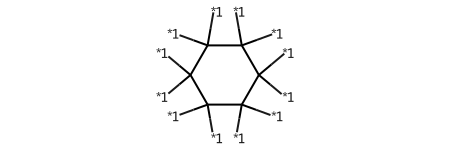

In [5]:
#one attachment point per atom
g_test = Group('cyclohexane', 'C1CCCCC1', all_attachment=True)
display(g_test.mol)

#multiple attachment points per atom
g_test2 = Group('cyclohexane2', 'C(*1)(*1)1C(*1)(*1)C(*1)(*1)C(*1)(*1)C(*1)(*1)C(*1)(*1)1')
display(g_test2.mol)


When the all attachment option is used, the `*number` notation is overloaded to subtract valency from that atom instead.

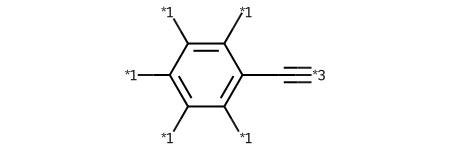

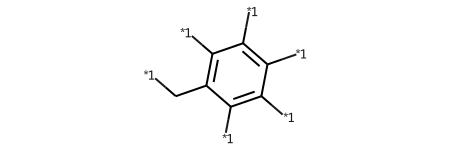

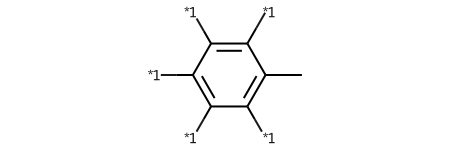

In [6]:
#default all attachment points
g3_test = Group('toluene', 'CC1=CC=CC=C1', all_attachment=True)
display(g3_test.mol)

#remove 2 valency from the methyl carbon, thereby making the attachment point have valency 1
g3_test = Group('toluene', 'C(*2)C1=CC=CC=C1', all_attachment=True)
display(g3_test.mol)

#remove 3 valency from the methyl carbon, thereby removing the attachment point
g3 = Group('toluene', 'C(*3)C1=CC=CC=C1', all_attachment=True)
display(g3.mol)


By default, the group extractor allows attachment points to be unfilled. However, in certain cases (e.g. chiral groups), it is useful to force certain attachment points to be filled in order to make a valid match. We specify this by adding an `x` before the number (e.g. `*x1`).

We can also specify a priority for the group, which determines in what order the group extractor will try and match groups. By default (or if the priorities are equal), the extractor matches the groups from largest to smallest. 

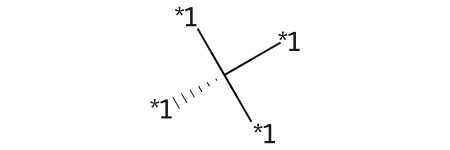

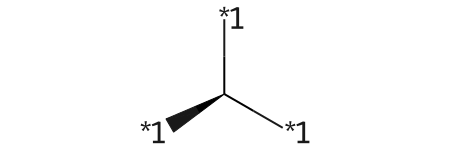

In [7]:
g4 = Group('chiral', '*x1[C@](*x1)(*x1)(*1)', None, priority=10) #at least 3 attachment points must be filled
g5 = Group('chiral2', '*x1[C@H](*x1)(*x1)', None, priority=10)
display(g4.mol)
display(g5.mol)

Now we can create a grammar out of the groups we specified:

In [8]:
grammar = GroupGrammar(vocab = {'trifluoromethane':g, 'pyrazole':g2, 'toluene':g3, 'chiral':g4, 'chiral2': g5}) #creating a grammar

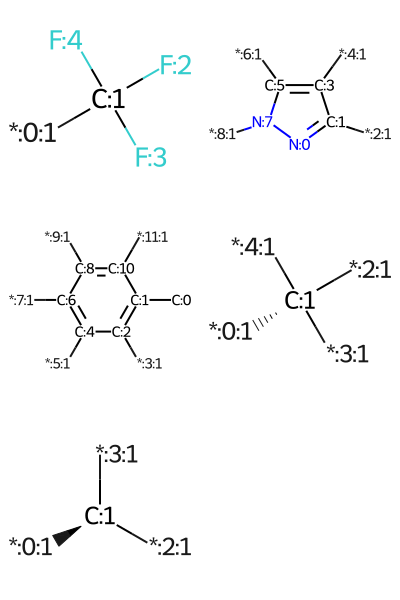

In [9]:
display(DrawMolsZoomed([g.mol, g2.mol, g3.mol, g4.mol, g5.mol], molsPerRow=2))

### Encoding

To encode a molecule, we first use `grammar.extract_groups` to extract group occurences in the molecule.

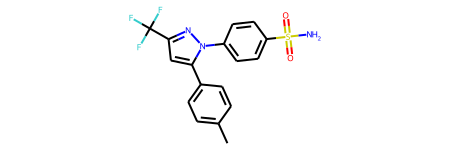

[(None toluene C-C1=C(*1)-C(*1)=C(*1)-C(*1)=C-1*1,
  [(0, 0), (1, 1), (2, 2), (3, 4), (4, 6), (5, 8), (6, 10)],
  [((7, 4), 7)]),
 (None pyrazole N1=C(*1)-C(*1)=C(*1)-N-1*1,
  [(10, 0), (9, 1), (8, 3), (7, 5), (11, 7)],
  [((22, 9), 2), ((4, 7), 6), ((12, 11), 8)]),
 (None trifluoromethane *1C(F)(F)F,
  [(22, 1), (23, 2), (24, 3), (25, 4)],
  [((9, 22), 0)])]

In [10]:
m = Chem.MolFromSmiles('CC1=CC=C(C=C1)C2=CC(=NN2C3=CC=C(C=C3)S(=O)(=O)N)C(F)(F)F') #celcoxib
display(m)
#extracting group matches from the molecule
extracted = grammar.extract_groups(m)
extracted

We then encode the molecule with these extracted groups using `grammar.encoder`

In [11]:
#encoding molecule
encoded = grammar.encoder(m, extracted)
encoded

'[:0toluene][Ring2][:2pyrazole][Ring2][:0trifluoromethane][pop][Branch][C][=C][C][=C][Branch][C][=C][Ring1][=Branch][pop][S][=Branch][=O][pop][=Branch][=O][pop][N][pop][pop]'

To simplify this process, you can also use `grammar.full_encoder` instead.

In [12]:
#extract and encode
encoded = grammar.full_encoder(m)
encoded

'[:0toluene][Ring2][:2pyrazole][Ring2][:0trifluoromethane][pop][Branch][C][=C][C][=C][Branch][C][=C][Ring1][=Branch][pop][S][=Branch][=O][pop][=Branch][=O][pop][N][pop][pop]'

### Decoding
To decode, use `grammar.decoder` on the encoded string. 

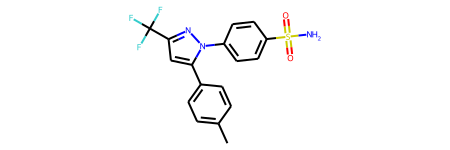

In [13]:
#decoding molecule
decoded = grammar.decoder(encoded)
decoded

Group SELFIES can encode most stereochemistry, including chirality and double bond isomerism. 

Original Compound:


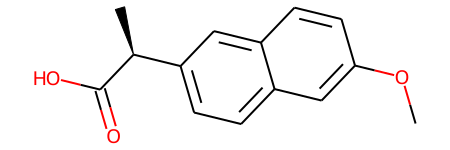

[C][O][C][=C][C][=C][C][=C][Branch][C][=C][Branch][C][=C][Ring1][=N][pop][Ring1][=Branch][pop][:0chiral2][Ring1][C][pop][Ring1][C][=Branch][=O][pop][O][pop]
Encoded-decoded Compound:


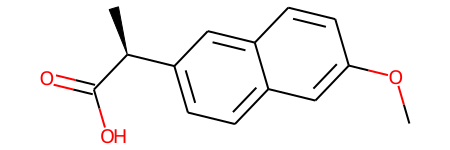

In [14]:
# chiral example

m2 = Chem.MolFromSmiles('COc1cc2ccc(cc2cc1)[C@H](C)C(=O)O')
print('Original Compound:')
display(m2)
extracted = grammar.extract_groups(m2)
encoded = grammar.encoder(m2, extracted)
print(encoded)
decoded = grammar.decoder(encoded)
print('Encoded-decoded Compound:')
display(decoded)

Original Compound:


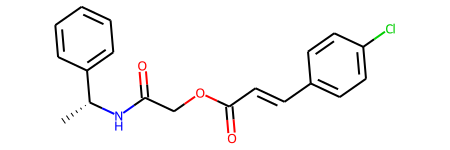

[C][:0chiral2][Ring2][N][C][=Branch][=O][pop][C][O][C][=Branch][=O][pop][/C][=C][/C][=C][C][=C][Branch][Cl][pop][C][=C][Ring1][#Branch][pop][Ring2][C][=C][C][=C][C][=C][Ring1][=Branch][pop]
Encoded-decoded Compound:


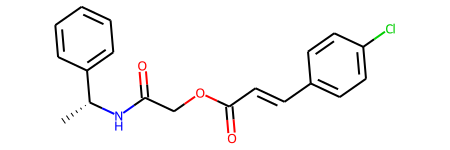

In [15]:
# double bond stereochem
m3 = Chem.MolFromSmiles('C[C@@H](NC(=O)COC(=O)/C=C/c1ccc(Cl)cc1)c1ccccc1')
print('Original Compound:')
display(m3)
extracted = grammar.extract_groups(m3)
encoded = grammar.encoder(m3, extracted)
print(encoded)
decoded = grammar.decoder(encoded)
print('Encoded-decoded Compound:')
display(decoded)

Grammars can also be saved to and loaded from a file easily. 

In [16]:
# Save, load and merge grammars

grammar.to_file('test_grammar.txt') #save
grammar2 = GroupGrammar(vocab={}) #empty grammar

#with no grammar
m = Chem.MolFromSmiles('CC1=CC=C(C=C1)C2=CC(=NN2C3=CC=C(C=C3)S(=O)(=O)N)C(F)(F)F')
extracted = grammar2.extract_groups(m)
encoded = grammar2.encoder(m, extracted)
print('Without loaded grammar:')
print(encoded)
print()
grammar2 = GroupGrammar.from_file('test_grammar.txt') #load

#with loaded grammar
extracted = grammar2.extract_groups(m)
encoded = grammar2.encoder(m, extracted)
print('With loaded grammar:')
print(encoded)


Without loaded grammar:
[C][C][=C][C][=C][Branch][C][=C][Ring1][=Branch][pop][C][=C][C][=Branch][=N][N][Branch][C][=C][C][=C][Branch][C][=C][Ring1][=Branch][pop][S][=Branch][=O][pop][=Branch][=O][pop][N][pop][Ring1][Branch][pop][C][Branch][F][pop][Branch][F][pop][F]

With loaded grammar:
[:0toluene][Ring2][:2pyrazole][Ring2][:0trifluoromethane][pop][Branch][C][=C][C][=C][Branch][C][=C][Ring1][=Branch][pop][S][=Branch][=O][pop][=Branch][=O][pop][N][pop][pop]


In order to fully specify all chirality, a certain set of groups must be included in your grammar. You can easily include this in your existing grammar by loading it in with `GroupGrammar.essential_set()` and merging it in with the `|` operator.

Original Compound:


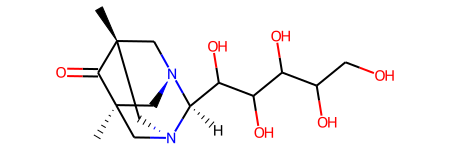


Without essential set:


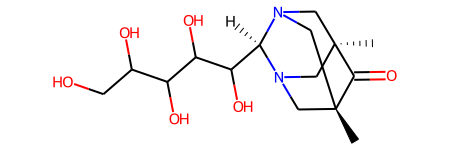

With essential set:


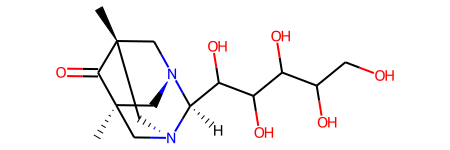

In [17]:
#test that fails without essential set
m = Chem.MolFromSmiles('C[C@]12C[N@]3C[C@](C)(C[N@](C1)[C@@H]3C(O)C(O)C(O)C(O)CO)C2=O')
print('Original Compound:')
display(m)
print()

#grammar without essential set
print('Without essential set:')
extracted = grammar.extract_groups(m)
encoded = grammar.encoder(m, extracted)
decoded = grammar.decoder(encoded)
display(decoded)

#load essential set and merge with current grammar
new_grammar = grammar | GroupGrammar.essential_set()

#grammar with essential set
print('With essential set:')
extracted = new_grammar.extract_groups(m)
encoded = new_grammar.encoder(m, extracted)
decoded = new_grammar.decoder(encoded)
display(decoded)

### Fragmentation
Because Group SELFIES relies heavily on the groups that are specified in the grammar, we have included a method which will extract reasonable groups from a set of molecules. This uses various fragmentation techniques along with custom optimizations. 

100%|██████████| 1000/1000 [01:44<00:00,  9.58it/s]


Custom


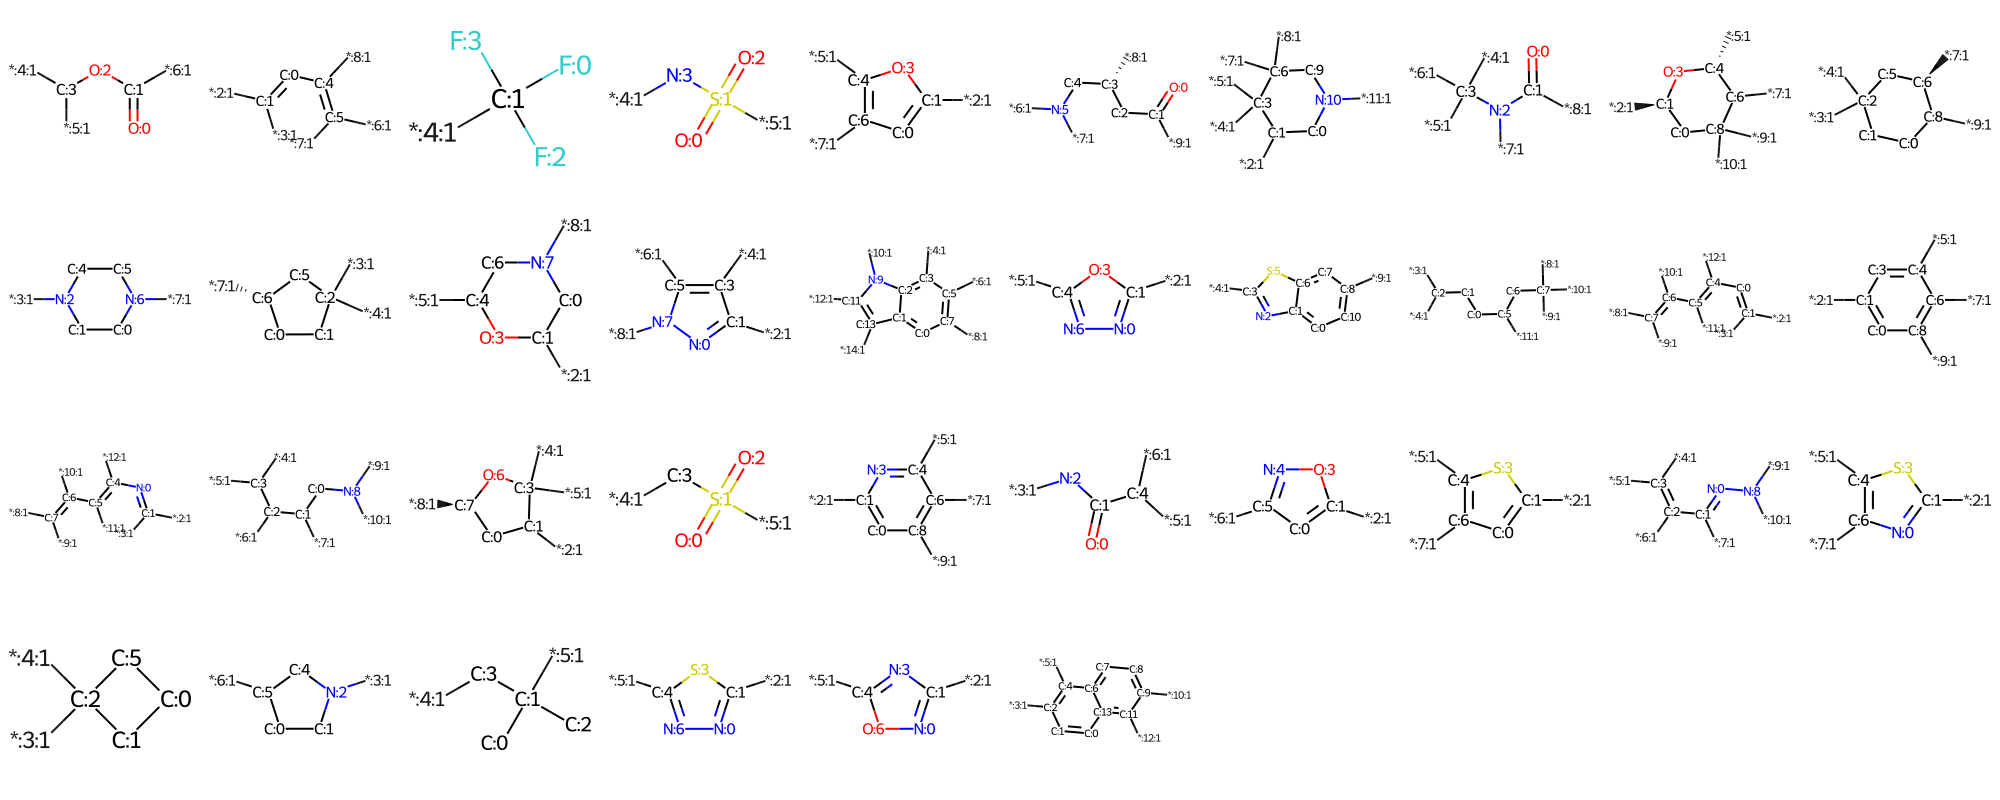

MMPA


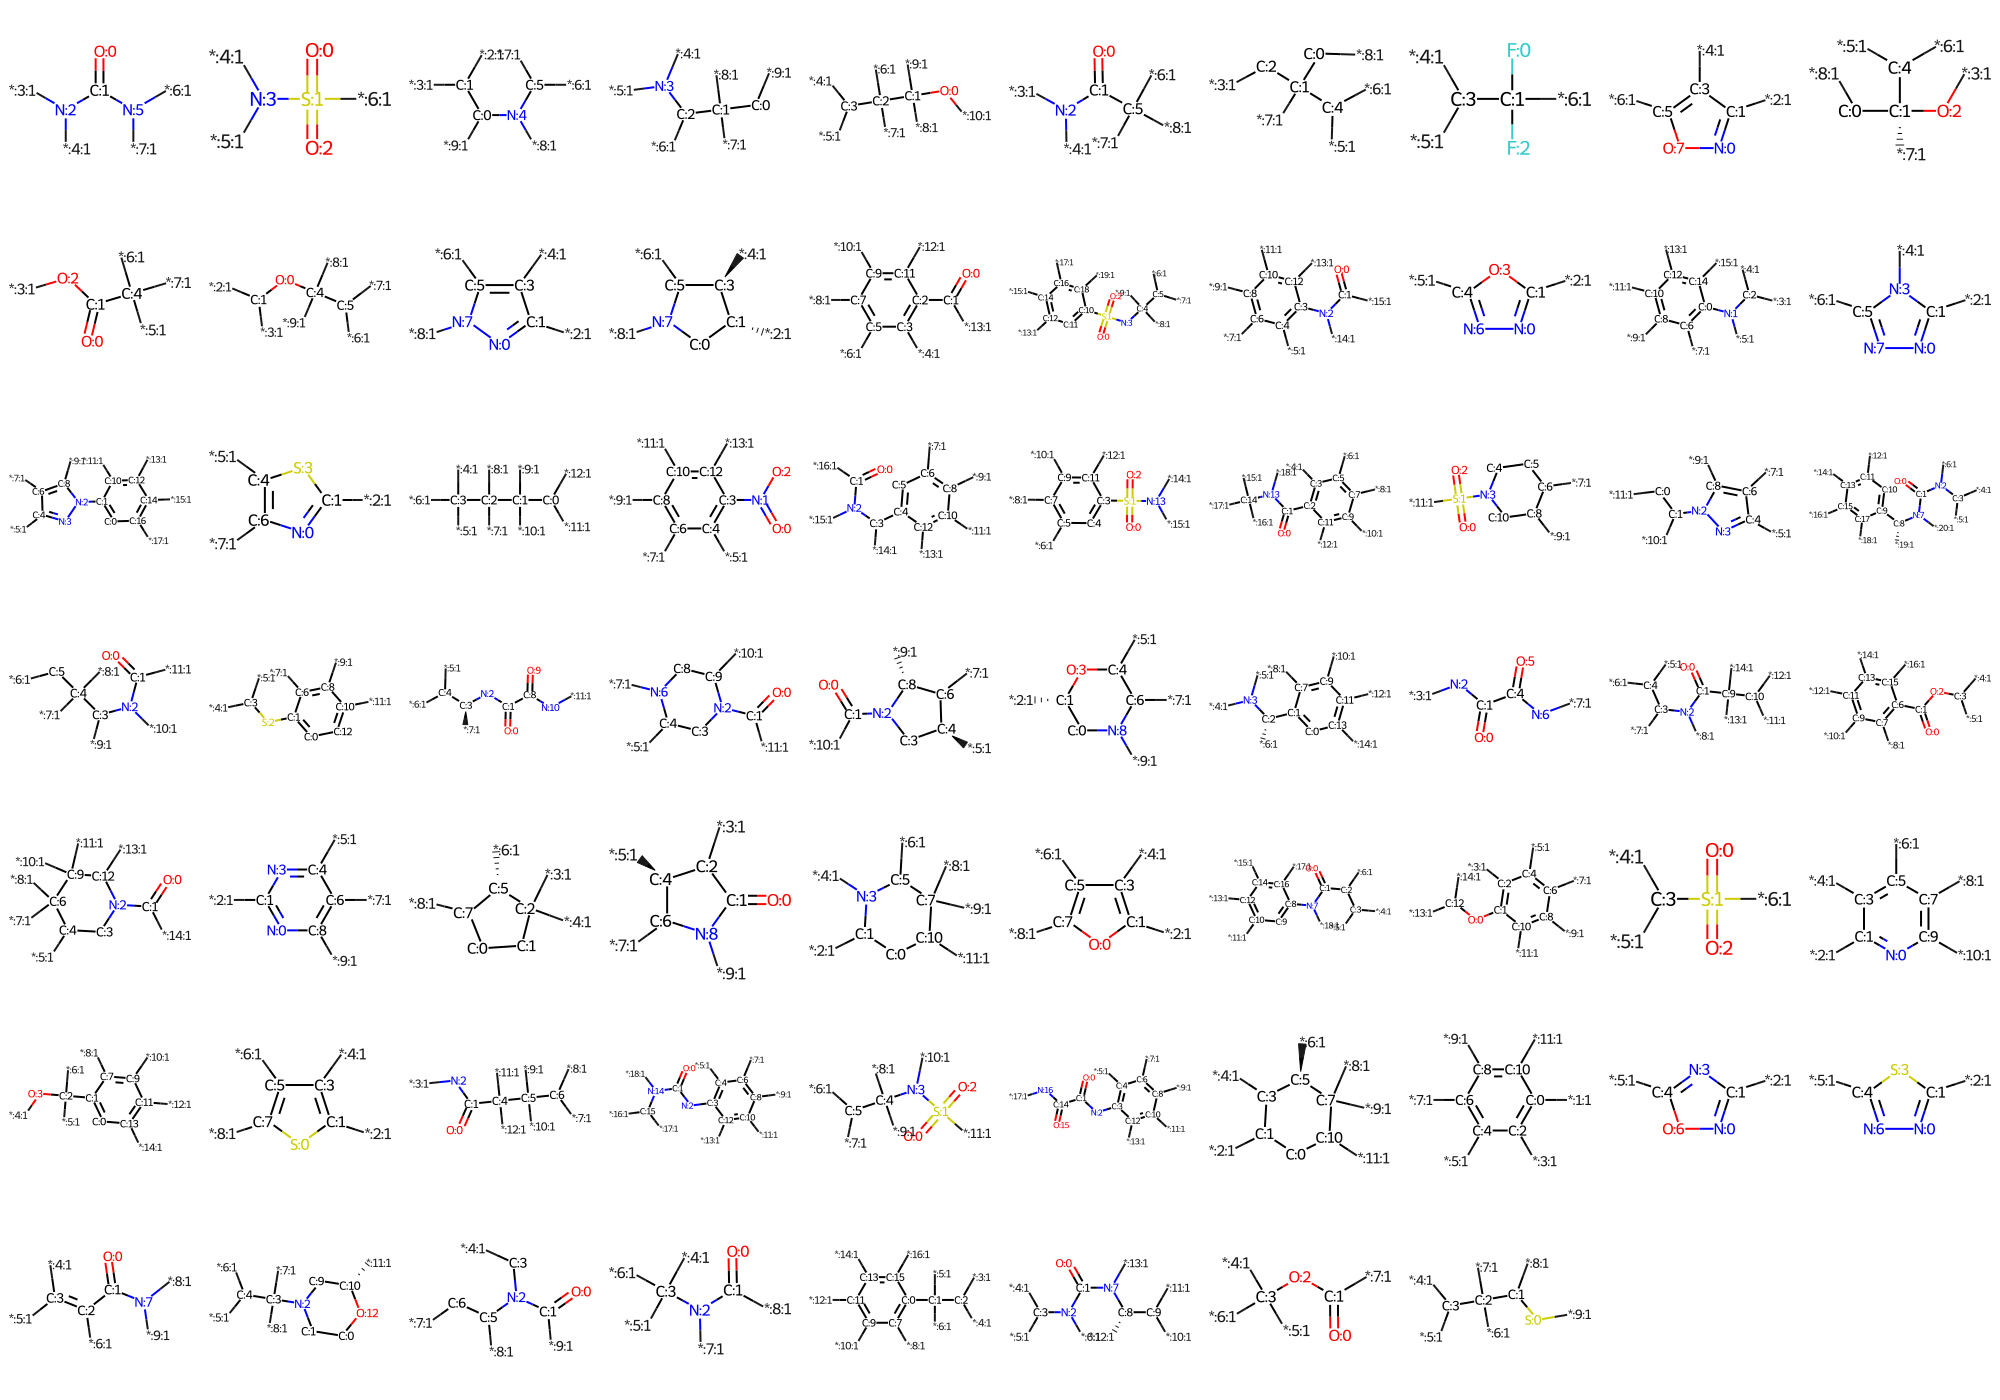

In [18]:
import random
random.seed(42)

# extracting a set of reasonable groups using fragmentation
zinc = [x.strip() for x in open('../tests/test_sets/zinc.csv')]
subset = random.sample(zinc, 1000)
fragments = fragment_mols(subset, convert=True, method='default') # use custom fragmentation technique
fragments_mmpa = fragment_mols(subset, convert=True, method='mmpa') # use MMPA fragmentation

vocab_fragment = dict([(f'frag{idx}', Group(f'frag{idx}', frag)) for idx, frag in enumerate(fragments)])
vocab_fragment_mmpa = dict([(f'frag{idx}', Group(f'frag{idx}', frag)) for idx, frag in enumerate(fragments_mmpa)])
print('Custom')
display(DrawMolsZoomed([g.mol for g in vocab_fragment.values()]))
print('MMPA')
display(DrawMolsZoomed([g.mol for g in vocab_fragment_mmpa.values()]))


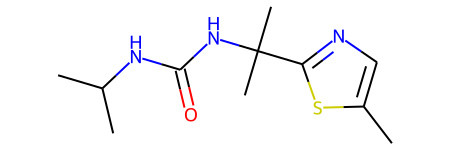

In [19]:
# testing group set on random molecule

random.seed(42)

grammar_fragment = GroupGrammar(vocab=vocab_fragment)
grammar_fragment_mmpa = GroupGrammar(vocab=vocab_fragment_mmpa)
test = Chem.MolFromSmiles(random.choice(zinc))
display(test)


Group Name: frag29


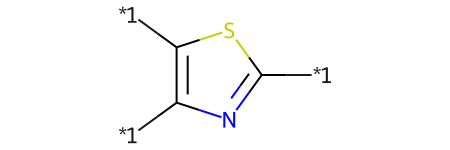

Group Name: frag7


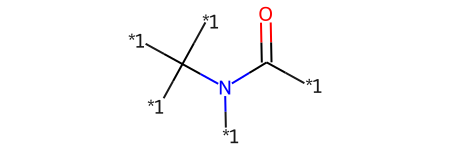

[C][:1frag29][Ring2][:0frag7][=Branch][N][C][Branch][C][pop][C][pop][Ring2][C][pop][Ring1][C][pop][pop]


In [20]:
#groups from the grammar using a custom fragmentation technique that appear in the molecule
extracted = grammar_fragment.extract_groups(test)
for group, _, _ in extracted:
    print('Group Name:', group.name)
    display(group.mol)
print(grammar_fragment.encoder(test, extracted))

Group Name: frag21


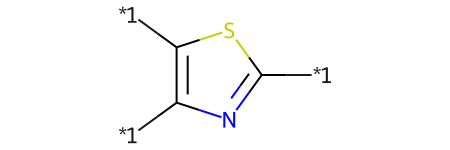

Group Name: frag0


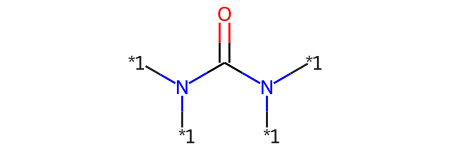

[C][:1frag21][Ring2][C][Branch][C][pop][Branch][C][pop][:0frag0][Ring2][C][Branch][C][pop][C][pop][pop]


In [21]:
#groups from the grammar using MMPA fragmentation that appear in the molecule

extracted = grammar_fragment_mmpa.extract_groups(test)
for group, _, _ in extracted:
    print('Group Name:', group.name)
    display(group.mol)
print(grammar_fragment_mmpa.encoder(test, extracted))